In [ ]:
import os
from dotenv import load_dotenv

# Load the environment variable file
load_dotenv()

# Get the API key
api_key = os.environ.get("ALPHA_VANTAGE_API_KEY")

if api_key is None:
    raise ValueError("Alpha Vantage API key is not set in the environment.")

In [ ]:
import requests
import pandas as pd
def get_stock_historical_data(api_key, stock_symbol):
    # Define the base URL and API parameters
    base_url = "https://www.alphavantage.co/query"
    function = "TIME_SERIES_DAILY"
    outputsize = "full"
    datatype = "json"
    params = {
        "function": function,
        "symbol": stock_symbol,
        "outputsize": outputsize,
        "datatype": datatype,
        "apikey": api_key
    }

    # Send API request and get JSON response
    response = requests.get(base_url, params=params)
    data = response.json()

    # Extract daily time series data
    time_series = data["Time Series (Daily)"]

    data_list = []
    for date, details in time_series.items():
        # Extract individual data points for each day
        row = {
            "Date": date,
            "Open": details["1. open"],
            "High": details["2. high"],
            "Low": details["3. low"],
            "Close": details["4. close"],
            "Volume": details["5. volume"]
        }
        data_list.append(row)

    # Create a Pandas DataFrame
    df = pd.DataFrame(data_list)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by="Date")

    # Save DataFrame to a CSV file
    csv_filename = f"{stock_symbol}_historical_data.csv"
    df.to_csv(csv_filename, index=False)

    print(f"Data saved to {csv_filename}")

# Example usage: Replace 'api_key' and 'stock_symbol' with your actual values
api_key = "4FHTO2GAT3NL1EZ8"
stock_symbol = "IYW"
get_stock_historical_data(api_key, stock_symbol)

In [ ]:


df_IYE = pd.read_csv('IYE_historical_data.csv')
df_IYE

,Date,Open,High,Low,Close,Volume
0,2000-06-16,51.61,51.78,51.55,51.77,2000
1,2000-06-19,51.53,51.53,50.63,50.63,2400
2,2000-06-20,50.11,50.11,49.78,49.78,1000
3,2000-06-21,50.44,51.70,50.44,51.67,3200
4,2000-06-22,51.92,51.92,50.52,50.53,2100
...,...,...,...,...,...,...
5829,2023-08-18,46.02,46.77,45.92,46.71,357874
5830,2023-08-21,46.91,47.12,46.17,46.48,435015
5831,2023-08-22,46.57,46.68,46.10,46.12,637860
5832,2023-08-23,45.71,46.05,45.28,46.00,449799


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np

def train_lstm_model(data_frame, features, target_column, sequence_length, output_length, split_ratio, num_epochs, batch_size):
    # Prepare input and output data
    x = data_frame[features].to_numpy()
    y = data_frame[target_column].to_numpy()

    # Normalize the input and output data
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    # Prepare sequence data
    sequences = []
    targets = []

    for i in range(len(y_scaled) - sequence_length - output_length):
        sequences.append(x_scaled[i:i+sequence_length])
        targets.append(y_scaled[i+sequence_length:i+sequence_length+output_length])

    # Convert lists to NumPy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)

    # Split into training and testing sets
    split_index = int(split_ratio * len(sequences))
    x_train = sequences[:split_index]
    y_train = targets[:split_index]
    x_test = sequences[split_index:]
    y_test = targets[split_index:]

    # Build LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, len(features))))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(64, return_sequences=False))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(25))
    model_lstm.add(Dense(output_length, activation='linear'))

    # Compile the model
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model_lstm.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)

    # Make predictions using the model
    predictions_scaled = model_lstm.predict(x_test)

    # Inverse normalize the predicted results
    predictions = scaler_y.inverse_transform(predictions_scaled)

    return model_lstm, predictions, y

# Example usage
data_frame = df_IYE  # Replace this with your actual dataframe
features = ["Open", "High", "Low", "Volume"]
target_column = "Close"
sequence_length = 100
output_length = 7  # Replace 60 with any desired output sequence length
split_ratio = 0.8
num_epochs = 50
batch_size = 32

model, predictions, y = train_lstm_model(data_frame, features, target_column, sequence_length, output_length, split_ratio, num_epochs, batch_size)



Epoch 1/50
115/115 [==============================] - 45s 287ms/step - loss: 0.0089 - val_loss: 2.1949e-04
Epoch 2/50
115/115 [==============================] - 27s 233ms/step - loss: 0.0028 - val_loss: 2.2224e-04
Epoch 3/50
115/115 [==============================] - 28s 244ms/step - loss: 0.0024 - val_loss: 1.0960e-04
Epoch 4/50
115/115 [==============================] - 27s 234ms/step - loss: 0.0022 - val_loss: 1.4764e-04
Epoch 5/50
115/115 [==============================] - 31s 270ms/step - loss: 0.0017 - val_loss: 1.9066e-04
Epoch 6/50
115/115 [==============================] - 27s 238ms/step - loss: 0.0015 - val_loss: 1.9075e-04
Epoch 7/50
115/115 [==============================] - 27s 237ms/step - loss: 0.0015 - val_loss: 1.1957e-04
Epoch 8/50
115/115 [==============================] - 28s 244ms/step - loss: 0.0015 - val_loss: 1.3511e-04
Epoch 9/50
115/115 [==============================] - 29s 255ms/step - loss: 0.0013 - val_loss: 9.5226e-05
Epoch 10/50
115/115 [================

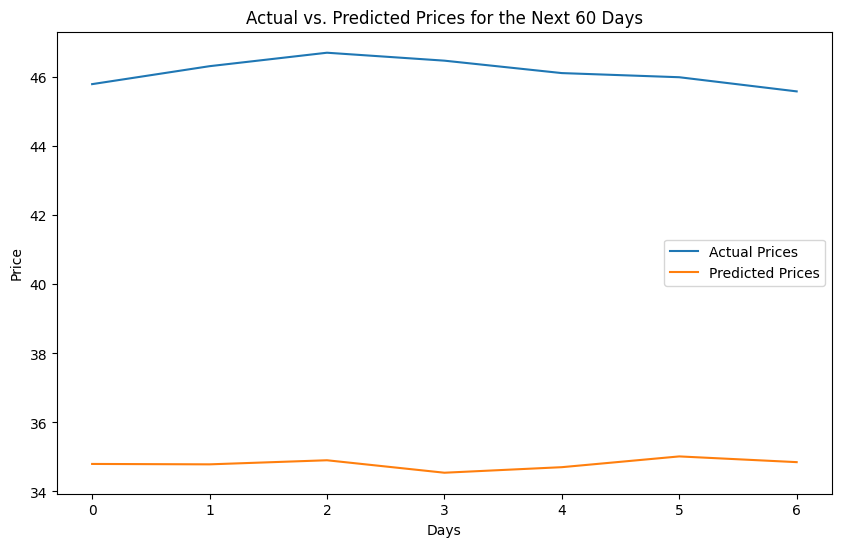

In [ ]:
import matplotlib.pyplot as plt

# Visualize the predicted results
plt.figure(figsize=(10, 6))
plt.plot(y[-7:], label='Actual Prices')
plt.plot(predictions[0], label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices for the Next 60 Days')
plt.legend()
plt.show()


In [ ]:
from keras.losses import mean_squared_error


y_test_2d = y_test.reshape(-1, 1)
predictions_2d = predictions.reshape(-1, 1)


rmse = np.sqrt(mean_squared_error(y_test_2d, predictions_2d))
rmse


array([34.6486  , 34.63613 , 34.750824, ..., 46.70564 , 47.12571 ,
       47.04684 ], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')